In [ ]:
#data: https://www.kaggle.com/datasets/stackoverflow/stack-overflow-2023-developers-survey/data
#this is a stack overflow survey that asks a bunch of questions to developers (experience,
    #education, age, role type, languages known, industry, whether or not they've worked
    #with certain tools like databases, AI, etc.)

#goal: predict the annual salary of a developer based on their survey answers

In [12]:
#imports & load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

df= pd.read_csv('survey_results_public.csv')
df[:3]

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0


In [13]:
#look at what we're working with
df.info()

#has 89,000+ rows, 84 columns
#each row represents a software developer
#each column represents a question posed on the survey

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

In [4]:
#select relevant cols
selected_cols= [
    'Age', 'Employment', 'RemoteWork', 'EdLevel', 'LearnCode',
    'LearnCodeCoursesCert', 'YearsCodePro', 'DevType', 'OrgSize', 'Country',
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith', 'AISelect', 'ICorPM',
    'Industry', 'ConvertedCompYearly'
]

df= df[selected_cols]

#bc there are 80+ questions, a lot of which were optional, we should focus on a subset of
    #questions that are most relevant to predicting salary

In [5]:
#if a user didn't answer a question, the value would be a string that said 'NA' as opposed
    #to an actual NaN value, so we have to replace those

#replace 'NA' strings w/ NaN
df.replace('NA', np.nan, inplace=True)

df_filtered= df

#remove rows w/ certain values (open-ended, etc.)
df_filtered= df_filtered[~df_filtered['Employment'].isin(['Not employed, but looking for work', 'Not employed, and not looking for work','Retired', 'I prefer not to say']) & ~df_filtered['Employment'].str.contains(';', na=False)]
df_filtered= df_filtered[~df_filtered['Age'].isin(['Prefer not to say'])]
df_filtered= df_filtered[~df_filtered['EdLevel'].isin(['Something else'])]
df_filtered= df_filtered[~df_filtered['LearnCode'].isin(['Colleague', 'Online Courses or Certification', 'Other (please specify):'])]
df_filtered= df_filtered[~df_filtered['DevType'].isin(['Other (please specify):'])]
df_filtered= df_filtered[~df_filtered['OrgSize'].isin(['I don’t know'])]
df_filtered= df_filtered[~df_filtered['Industry'].isin(['Other'])]

#drop rows where important cols != NaN
df_filtered= df_filtered.dropna(subset=[
    'Age', 'Employment', 'RemoteWork', 'EdLevel', 'LearnCode', 
    'YearsCodePro', 'DevType', 'OrgSize', 'Country', 'LanguageHaveWorkedWith', 'ICorPM',
    'Industry', 'ConvertedCompYearly'
])

#filter to only USA
df_filtered= df_filtered[df_filtered['Country'] == 'United States of America']

#grouped certain cols and converted to binary
#basically if a user answered yes to any of the questions the value = 1, and 0 otherwise
df_filtered['LearnCodeCoursesCert']= df_filtered['LearnCodeCoursesCert'].apply(lambda x: 1 if pd.notna(x) else 0)
df_filtered['DatabaseHaveWorkedWith']= df_filtered['DatabaseHaveWorkedWith'].apply(lambda x: 1 if pd.notna(x) else 0)
df_filtered['PlatformHaveWorkedWith']= df_filtered['PlatformHaveWorkedWith'].apply(lambda x: 1 if pd.notna(x) else 0)
df_filtered['WebframeHaveWorkedWith']= df_filtered['WebframeHaveWorkedWith'].apply(lambda x: 1 if pd.notna(x) else 0)
df_filtered['ToolsTechHaveWorkedWith']= df_filtered['ToolsTechHaveWorkedWith'].apply(lambda x: 1 if pd.notna(x) else 0)
df_filtered['NEWCollabToolsHaveWorkedWith']= df_filtered['NEWCollabToolsHaveWorkedWith'].apply(lambda x: 1 if pd.notna(x) else 0)
df_filtered['AISelect']= df_filtered['AISelect'].apply(lambda x: 1 if x == 'Yes' else 0)

#save filtered df to csv
df_filtered.to_csv('df_filtered.csv', index=False)
df_filtered.head()

,Age,Employment,RemoteWork,EdLevel,LearnCode,LearnCodeCoursesCert,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,ToolsTechHaveWorkedWith,NEWCollabToolsHaveWorkedWith,AISelect,ICorPM,Industry,ConvertedCompYearly
1,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,1,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,HTML/CSS;JavaScript;Python,1,1,1,1,1,1,People manager,"Information Services, IT, Software Development...",285000.0
2,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,0,23,"Developer, back-end","5,000 to 9,999 employees",United States of America,Bash/Shell (all shells);Go,0,1,0,1,1,0,Individual contributor,"Information Services, IT, Software Development...",250000.0
6,35-44 years old,"Employed, full-time",Remote,Some college/university study without earning ...,Friend or family member;Online Courses or Cert...,1,3,"Developer, full-stack","1,000 to 4,999 employees",United States of America,Ada;Clojure;Elixir;Go;HTML/CSS;Java;JavaScript...,1,1,1,1,1,1,Individual contributor,"Information Services, IT, Software Development...",135000.0
13,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Online Courses or Certi...,1,Less than 1 year,"Developer, QA or test","10,000 or more employees",United States of America,C;C++;Python;Rust,1,0,0,1,1,1,Individual contributor,"Information Services, IT, Software Development...",150000.0
36,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Some college/university study without earning ...,Books / Physical media;Online Courses or Certi...,1,15,"Developer, full-stack",100 to 499 employees,United States of America,C#;HTML/CSS;JavaScript;SQL;TypeScript,1,1,1,1,1,1,Individual contributor,"Manufacturing, Transportation, or Supply Chain",130000.0


In [6]:
#LearnCode question asks the user where they learned to code, but it was multiple select,
    #so converted to binary that way we don't have to deal with text extraction

#convert LearnCode to multiple binary columns
learn_code_options= [
    'Books / Physical media', 'Coding Bootcamp', 'Friend or family member', 'Hackathons (virtual or in-person)',
    'Online Courses or Certification', 'On the job training', 'Other online resources (e.g., videos, blogs, forum)',
    'School (i.e., University, College, etc)'
]

for option in learn_code_options: #initialize cols w/ 0
    col_name= 'learnedCodeVia' + option.replace(' ', '').replace('/', '').replace('(', '').replace(')', '').replace('-', '').replace(',', '').replace(';', '').replace('.', '')
    df_filtered[col_name]= 0
    
for option in learn_code_options: #populate cols
    col_name= 'learnedCodeVia' + option.replace(' ', '').replace('/', '').replace('(', '').replace(')', '').replace('-', '').replace(',', '').replace(';', '').replace('.', '')
    df_filtered[col_name]= df_filtered['LearnCode'].apply(lambda x: 1 if option in str(x).split(';') else 0)
    
#drop original LearnCode column
df_filtered.drop(columns=['LearnCode'], inplace=True)

#save filtered df to csv
df_filtered.to_csv('df_filtered.csv', index=False)
df_filtered.head()

,Age,Employment,RemoteWork,EdLevel,LearnCodeCoursesCert,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,...,Industry,ConvertedCompYearly,learnedCodeViaBooksPhysicalmedia,learnedCodeViaCodingBootcamp,learnedCodeViaFriendorfamilymember,learnedCodeViaHackathonsvirtualorinperson,learnedCodeViaOnlineCoursesorCertification,learnedCodeViaOnthejobtraining,learnedCodeViaOtheronlineresourcesegvideosblogsforum,learnedCodeViaSchoolieUniversityCollegeetc
1,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,HTML/CSS;JavaScript;Python,...,"Information Services, IT, Software Development...",285000.0,1,0,1,1,1,1,1,1
2,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0,23,"Developer, back-end","5,000 to 9,999 employees",United States of America,Bash/Shell (all shells);Go,...,"Information Services, IT, Software Development...",250000.0,1,0,0,0,0,1,1,1
6,35-44 years old,"Employed, full-time",Remote,Some college/university study without earning ...,1,3,"Developer, full-stack","1,000 to 4,999 employees",United States of America,Ada;Clojure;Elixir;Go;HTML/CSS;Java;JavaScript...,...,"Information Services, IT, Software Development...",135000.0,0,1,1,0,1,0,0,0
13,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1,Less than 1 year,"Developer, QA or test","10,000 or more employees",United States of America,C;C++;Python;Rust,...,"Information Services, IT, Software Development...",150000.0,1,0,0,0,1,0,1,1
36,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Some college/university study without earning ...,1,15,"Developer, full-stack",100 to 499 employees,United States of America,C#;HTML/CSS;JavaScript;SQL;TypeScript,...,"Manufacturing, Transportation, or Supply Chain",130000.0,1,0,0,0,1,1,1,0


In [7]:
#LearnCode question asks the user where they learned to code, but it was multiple select,
    #so converted to binary that way we don't have to deal with text extraction.

#there were SO many niche languages, so we focused on specified languages and then
    #converted to multiple binary columns just as in LearnCode
languages= {
    'C-family': ['C', 'C#', 'C++'],
    'HTML/CSS': ['HTML/CSS'],
    'Java-family': ['Java', 'JavaScript'],
    'Julia': ['Julia'],
    'MATLAB': ['MATLAB'],
    'Python': ['Python'],
    'R': ['R'],
    'Ruby': ['Ruby'],
    'SQL': ['SQL'],
    'Swift': ['Swift'],
    'VBA': ['VBA']
}

for lang in languages.keys(): #initialize cols w/ 0
    col_name= 'languageUsed' + lang.replace(' ', '').replace('/', '').replace('(', '').replace(')', '').replace('-', '').replace(',', '').replace(';', '').replace('.', '')
    df_filtered[col_name]= 0

for lang, variants in languages.items(): #populate cols
    col_name= 'languageUsed' + lang.replace(' ', '').replace('/', '').replace('(', '').replace(')', '').replace('-', '').replace(',', '').replace(';', '').replace('.', '')
    df_filtered[col_name]= df_filtered['LanguageHaveWorkedWith'].apply(lambda x: 1 if any(variant in str(x).split(';') for variant in variants) else 0)

#drop original LanguageHaveWorkedWith column
df_filtered.drop(columns=['LanguageHaveWorkedWith'], inplace=True)

#save filtered df to csv
df_filtered.to_csv('df_filtered.csv', index=False)
df_filtered.head()

,Age,Employment,RemoteWork,EdLevel,LearnCodeCoursesCert,YearsCodePro,DevType,OrgSize,Country,DatabaseHaveWorkedWith,...,languageUsedHTMLCSS,languageUsedJavafamily,languageUsedJulia,languageUsedMATLAB,languageUsedPython,languageUsedR,languageUsedRuby,languageUsedSQL,languageUsedSwift,languageUsedVBA
1,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,1,...,1,1,0,0,1,0,0,0,0,0
2,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0,23,"Developer, back-end","5,000 to 9,999 employees",United States of America,0,...,0,0,0,0,0,0,0,0,0,0
6,35-44 years old,"Employed, full-time",Remote,Some college/university study without earning ...,1,3,"Developer, full-stack","1,000 to 4,999 employees",United States of America,1,...,1,1,0,0,0,0,1,0,1,0
13,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1,Less than 1 year,"Developer, QA or test","10,000 or more employees",United States of America,1,...,0,0,0,0,1,0,0,0,0,0
36,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Some college/university study without earning ...,1,15,"Developer, full-stack",100 to 499 employees,United States of America,1,...,1,1,0,0,0,0,0,1,0,0


In [9]:
df_filtered.info()

#df now has about 5000 rows & 37 columns; MUCH easier to run modeling with

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5143 entries, 1 to 89156
Data columns (total 37 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age                                                   5143 non-null   object 
 1   Employment                                            5143 non-null   object 
 2   RemoteWork                                            5143 non-null   object 
 3   EdLevel                                               5143 non-null   object 
 4   LearnCodeCoursesCert                                  5143 non-null   int64  
 5   YearsCodePro                                          5143 non-null   object 
 6   DevType                                               5143 non-null   object 
 7   OrgSize                                               5143 non-null   object 
 8   Country                                               514

In [29]:
df_filtered.isnull().sum()

#clean data with no null vals

Age                                                     0
Employment                                              0
RemoteWork                                              0
EdLevel                                                 0
LearnCodeCoursesCert                                    0
YearsCodePro                                            0
DevType                                                 0
OrgSize                                                 0
Country                                                 0
DatabaseHaveWorkedWith                                  0
PlatformHaveWorkedWith                                  0
WebframeHaveWorkedWith                                  0
ToolsTechHaveWorkedWith                                 0
NEWCollabToolsHaveWorkedWith                            0
AISelect                                                0
ICorPM                                                  0
Industry                                                0
ConvertedCompY

### EDA

#### Summary statistics

In [32]:
#distribution of categorical variable 'DevType'
df_filtered['DevType'].value_counts()

Developer, full-stack                            2011
Developer, back-end                              1007
Developer, front-end                              285
Developer, desktop or enterprise applications     266
Engineering manager                               198
Developer, mobile                                 137
Developer, embedded applications or devices       135
Cloud infrastructure engineer                     134
Engineer, data                                    115
DevOps specialist                                 101
Senior Executive (C-Suite, VP, etc.)              100
Data scientist or machine learning specialist      99
Research & Development role                        84
Engineer, site reliability                         61
Developer, QA or test                              46
Data or business analyst                           46
Security professional                              37
System administrator                               36
Developer Experience        

In [33]:
#distribution of categorical variable 'Age'
df_filtered['Age'].value_counts()

25-34 years old       2192
35-44 years old       1606
45-54 years old        622
18-24 years old        390
55-64 years old        285
65 years or older       47
Under 18 years old       1
Name: Age, dtype: int64

In [34]:
#distribution of categorical variable 'Employment'
df_filtered['Employment'].value_counts()

Employed, full-time                                     5031
Independent contractor, freelancer, or self-employed      90
Employed, part-time                                       22
Name: Employment, dtype: int64

In [35]:
#distribution of categorical variable 'RemoteWork'
df_filtered['RemoteWork'].value_counts()

Remote                                  2957
Hybrid (some remote, some in-person)    1683
In-person                                503
Name: RemoteWork, dtype: int64

In [36]:
#distribution of categorical variable 'EdLevel'
df_filtered['EdLevel'].value_counts()

#majority of devs have a bachelor's as their highest form of education

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          3113
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        943
Some college/university study without earning a degree                                 566
Associate degree (A.A., A.S., etc.)                                                    232
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         175
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)      99
Primary/elementary school                                                               15
Name: EdLevel, dtype: int64

In [37]:
#distribution of categorical variable 'LearnCodeCoursesCert'
df_filtered['LearnCodeCoursesCert'].value_counts()

#nearly 40% of devs have received an online course certification

0    3147
1    1996
Name: LearnCodeCoursesCert, dtype: int64

In [39]:
#distribution of categorical variable 'OrgSize'
df_filtered['OrgSize'].value_counts()

10,000 or more employees                              1185
100 to 499 employees                                   992
20 to 99 employees                                     894
1,000 to 4,999 employees                               742
500 to 999 employees                                   423
5,000 to 9,999 employees                               305
2 to 9 employees                                       298
10 to 19 employees                                     289
Just me - I am a freelancer, sole proprietor, etc.      15
Name: OrgSize, dtype: int64

In [40]:
#distribution of categorical variable 'Industry'
df_filtered['Industry'].value_counts()

Information Services, IT, Software Development, or other Technology    2326
Financial Services                                                      745
Healthcare                                                              542
Manufacturing, Transportation, or Supply Chain                          485
Retail and Consumer Services                                            376
Higher Education                                                        214
Insurance                                                               189
Advertising Services                                                    164
Oil & Gas                                                                46
Legal Services                                                           33
Wholesale                                                                23
Name: Industry, dtype: int64

In [45]:
#average yearly compensation (USD)
df['ConvertedCompYearly'].mean()

#we can groupby to find average salary for things like industry, age, education level, etc.

103110.08171765343

#### Visualizations

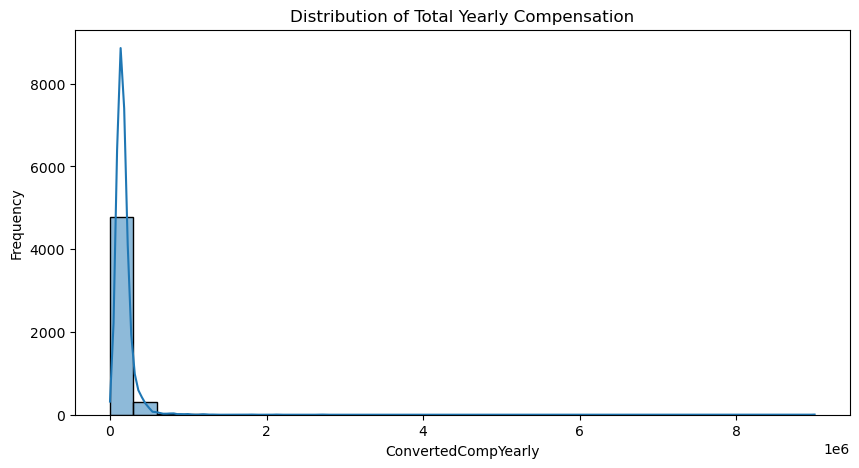

In [43]:
#distribution for ConvertedCompYearly
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['ConvertedCompYearly'], bins=30, kde=True)
plt.title('Distribution of Total Yearly Compensation')
plt.xlabel('ConvertedCompYearly')
plt.ylabel('Frequency')
plt.show()

### need to convert from scientific notation & take out outliers

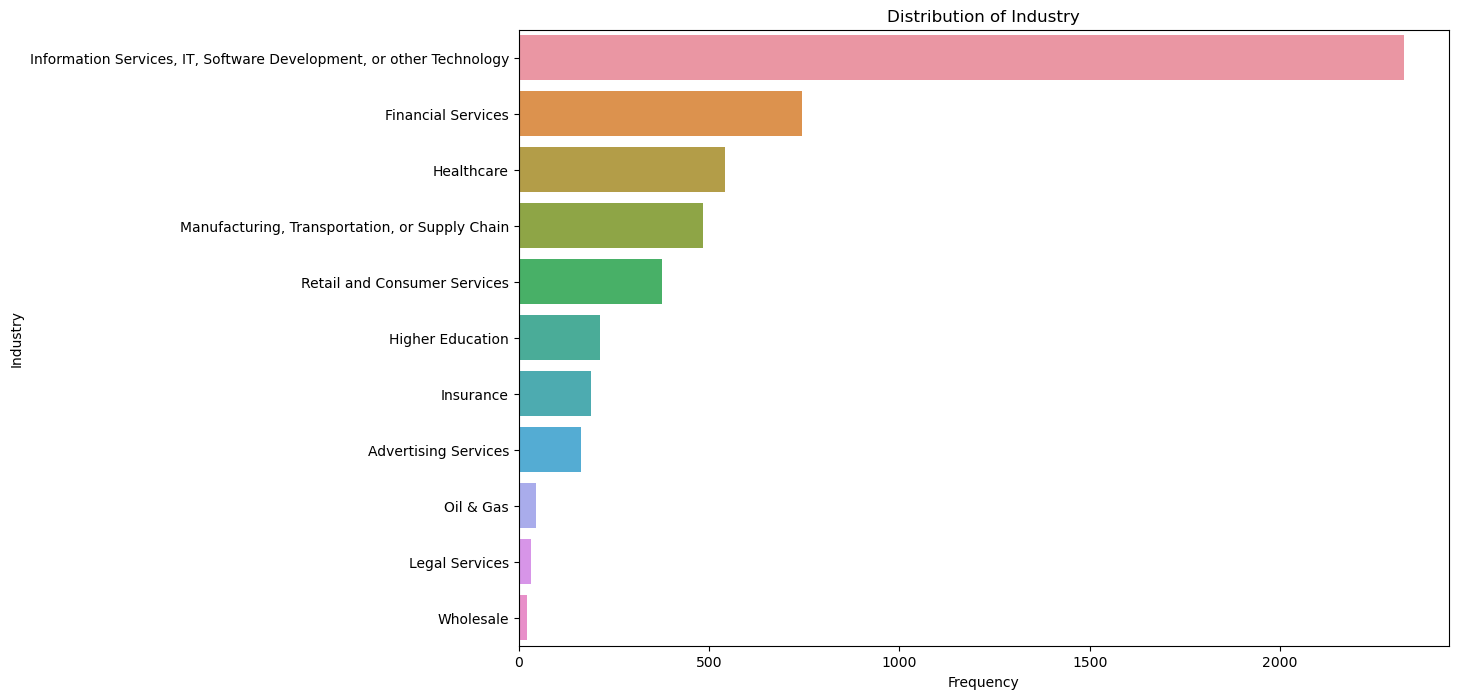

In [52]:
#distribution for Industry
plt.figure(figsize=(12, 8))
sns.countplot(y='Industry', data=df_filtered, order=df_filtered['Industry'].value_counts().index)
plt.title('Distribution of Industry')
plt.xlabel('Frequency')
plt.ylabel('Industry')
plt.show()

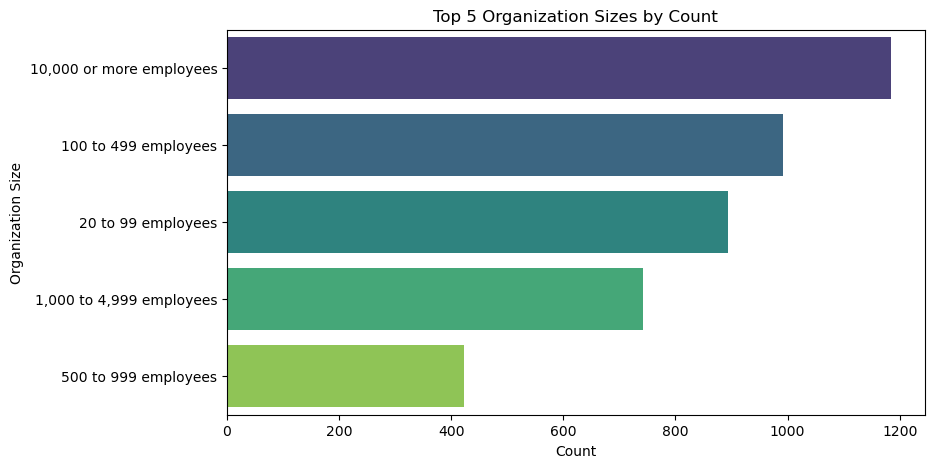

In [62]:
#get top 5 of 'OrgSize'
top5_orgsize= df_filtered['OrgSize'].value_counts().nlargest(5)

#plot
plt.figure(figsize=(9, 5))
sns.barplot(x=top5_orgsize.values, y=top5_orgsize.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Organization Size')
plt.title('Top 5 Organization Sizes by Count')
plt.show()